In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-

# 1 Read facies images from Training dataset

In [2]:
import sys
# Code directory path
new_path = 'H:/UnconditionalData/'
sys.path.append(new_path)
import dataset
import config

import tensorflow as tf
# Initialize TensorFlow session.
tf.InteractiveSession()

training_set = dataset.load_dataset(data_dir=config.data_dir, verbose=True, **config.dataset)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Colocations handled automatically by placer.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]


In [3]:
fm_no = 300
allimgs = training_set.get_minibatch_np(fm_no)  # real is the sampled training facies models, which is range 0-255.
allimgs_max = np.max(allimgs, axis = (2, 3), keepdims = True)
allimgs_min = np.min(allimgs, axis = (2, 3), keepdims = True)
allimgs = (allimgs - allimgs_min)/(allimgs_max - allimgs_min)

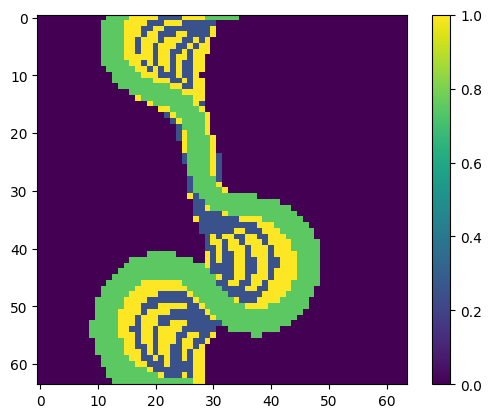

In [4]:
plt.imshow(allimgs[3,0])
plt.colorbar()

In [5]:
allimgs.shape

(300, 1, 64, 64)

In [6]:
allimgs = np.where(allimgs<0.15, 0, allimgs)
allimgs = np.where((allimgs>= 0.15) & (allimgs<0.50), 0.25, allimgs)
allimgs = np.where((allimgs>= 0.50) & (allimgs<0.85), 0.75, allimgs)
allimgs = np.where(allimgs>= 0.85, 1, allimgs)

In [7]:
var_num = 300

### 2 Read facies images generated from Trained GAN

In [9]:
import pickle

In [10]:
network_dir = 'H:/110-pgan-1gpu-yunjisuan/'
network_name = 'network-snapshot-006400.pkl'

In [11]:
import pickle

# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)
    
del G

C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
import config
import tfutil

resolution_x = 64
resolution_y = 64

latent_size_x = int(resolution_x/16)
latent_size_y = int(resolution_y/16)

Gs_enlarged = tfutil.Network('Gs_enlarged', num_channels=1, resolution_x = resolution_x, resolution_y = resolution_y, latent_size_x = latent_size_x,latent_size_y = latent_size_y, **config.G) #

In [13]:
print(Gs_enlarged.input_shapes)

[[Dimension(None), Dimension(8), Dimension(4), Dimension(4)]]


In [14]:
Gs_enlarged.copy_trainables_from(Gs)

In [15]:
del Gs

In [16]:
TotalReal_no = fm_no
Fakemodels_final = np.zeros(([1]+[TotalReal_no]+[resolution_x]+[resolution_y]), dtype=np.float32) # dimension = [35640, 8, 1, 64, 64]

for j in range(1):
    images_plt = np.zeros([TotalReal_no, 1, resolution_x, resolution_y])
    latents = np.random.RandomState(412).randn(TotalReal_no, 8, latent_size_x, latent_size_y)   #
    for i in range(int(TotalReal_no/1)):
        latents1 = latents[i*1:(i+1)*1]
        fakemodels = Gs_enlarged.run(latents1)
        fakemodels_max = np.max(fakemodels, axis = (2, 3), keepdims = True)
        fakemodels_min = np.min(fakemodels, axis = (2, 3), keepdims = True)
        fakemodels = (fakemodels - fakemodels_min)/(fakemodels_max - fakemodels_min)
        fakemodels = np.where(fakemodels<0.15, 0, fakemodels)
        fakemodels = np.where((fakemodels>= 0.15) & (fakemodels<0.50), 0.25, fakemodels)
        fakemodels = np.where((fakemodels>= 0.50) & (fakemodels<0.85), 0.75, fakemodels)
        fakemodels = np.where(fakemodels>= 0.85, 1, fakemodels)
        images_plt[i*1:(i+1)*1] = fakemodels

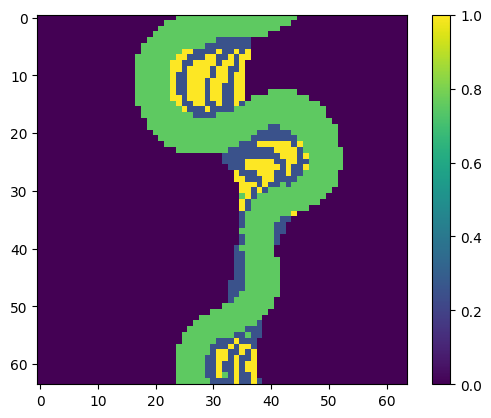

In [17]:
plt.imshow(images_plt[9,0])
plt.colorbar()

## 3 Read facies images generated from MPS generated data

In [19]:
partimgs = np.load('H:/DeeSseOutput.npy')
partimgs = partimgs/4

In [20]:
partimgs[0]

array([[[0.  , 0.  , 0.  , ..., 0.75, 0.75, 0.75],
        [0.  , 0.  , 0.  , ..., 0.75, 0.75, 0.75],
        [0.  , 0.  , 0.  , ..., 0.75, 0.75, 0.75],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]])

In [21]:
partimgs.shape

(500, 1, 64, 64)

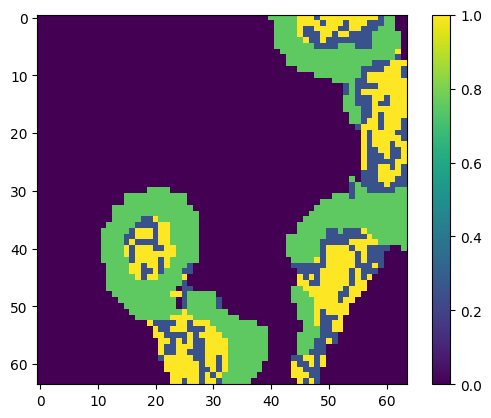

In [22]:
plt.imshow(partimgs[200,0])
plt.colorbar()

In [23]:
partimgs1 = []
for k in range(partimgs.shape[0]):
    if np.sum(partimgs[k]) > 300:
        partimgs1.append(partimgs[k])

In [24]:
partimgs = np.array(partimgs1,dtype=np.float32)
print(partimgs.shape)

(471, 1, 64, 64)


# 4 Make Multiscale-pyramid-sliced Wasserstein based MDS plot

In [27]:
def pyr_down(model): # matches cv2.pyrDown()
    assert model.ndim == 3
    return np.expand_dims(scipy.ndimage.gaussian_filter(model[0], (2, 2), mode='mirror')[::2,::2], axis = 0)

def pyr_up(minibatch): # matches cv2.pyrUp()
    assert minibatch.ndim == 3
    S = minibatch.shape
    res = np.zeros((S[0], S[1] * 2, S[2] * 2), minibatch.dtype)
    res[:, ::2, ::2] = minibatch
    return np.expand_dims(scipy.ndimage.gaussian_filter(res[0], (2, 2), mode='mirror') * 4, axis = 0) 

def generate_laplacian_pyramid(model, num_levels):  # model with shape of [1,64,64,64],num_levels = 3
    pyramid = [np.float32(model)]
    for i in range(1, num_levels):
        pyramid.append(pyr_down(pyramid[-1])) # pyramid[-1].shape = [1,64,64]
        pyramid[-2] -= pyr_up(pyramid[-1])
    return pyramid

def get_descriptors_for_minibatch(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, length, width, height)  [1, 64, 64, 64]
    assert len(S) == 3
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, x, y = np.ogrid[0:N,-H:H+1, -H:H+1] # x.shape = [1,5,1],y.sahpe = [1,1,5]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[1] - H, size=(N, 1, 1)) # x.shape = [24,1,5,1]
    y = y + np.random.randint(H, S[2] - H, size=(N, 1, 1)) # x.shape = [24,1,1,5]
    idx = (img * S[1] + x) * S[2] + y # idx.shape = [24,24,5,5]
    return minibatch.flat[idx]

def finalize_descriptors(desc):
    if isinstance(desc, list):
        desc = np.concatenate(desc, axis=0)
    assert desc.ndim == 3 # (neighborhood, length, width, height)
    desc -= np.mean(desc, axis=(0, 1, 2), keepdims=True)
    desc /= np.std(desc, axis=(0, 1, 2), keepdims=True)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def sliced_wasserstein(A, B, dir_repeats, dirs_per_repeat):
    assert A.ndim == 2 and A.shape == B.shape                           # (neighborhood, descriptor_component)
    results = []
    for repeat in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)             # (descriptor_component, direction)
        # print(A.shape[1])
        dirs /= np.sqrt(np.sum(np.square(dirs), axis=0, keepdims=True)) # normalize descriptor components for each direction
        dirs = dirs.astype(np.float32)
        projA = np.matmul(A, dirs)                                      # (neighborhood, direction)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)                                  # sort neighborhood projections for each direction
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)                                   # pointwise wasserstein distances
        results.append(np.mean(dists))                                  # average over neighborhoods and directions
    return np.mean(results)                                             # average over repeats

In [28]:
# realcubes_test_400:  400 test facies models,  (400, 1, 64, 64, 64), 0 to 1
# condfakemodels:  400 produced conditional facies models,  (400, 1, 64, 64, 64), -1 to 1

from scipy import signal
from scipy.ndimage.filters import convolve
from sklearn import manifold
from scipy.stats import kde
import scipy.ndimage

# MDS map for 200 test facies models, 50 produced facies models, and 1 ground truth facies models orderly
Test_mds_num = 200
MPS_mds_num = 200
GAN_mds_num = 200
Test_mds = allimgs[0:Test_mds_num]
MPS_generated_models_mds = partimgs[0:MPS_mds_num]
GAN_generated_models_mds = images_plt[0:GAN_mds_num]
allmodels_mds = np.squeeze(np.concatenate((Test_mds, MPS_generated_models_mds, GAN_generated_models_mds), axis = 0))  # shape [251, 64, 64, 64]
print(allmodels_mds.shape)

nhood_size         = 10   # neighborhood size, 5x5 default:5
nhoods_per_cube   = 24 # default:24
dir_repeats        = 8 # default:4
dirs_per_repeat    = 32
resolutions = [64]  # pyramid resolutions 

groups_lap = []
for i in range(Test_mds_num+MPS_mds_num+GAN_mds_num):
    descriptors = [[] for res in resolutions]
    for lod, level in enumerate(generate_laplacian_pyramid(allmodels_mds[i:i+1], len(resolutions))):
        desc = get_descriptors_for_minibatch(level, nhood_size, nhoods_per_cube)
        descriptors[lod].append(desc)
    groups_lap.append(descriptors) # len(groups_lap) = 151
    # lod = allmodels_mds[i:i+1]
    # level = len(resolutions)
    # desc = get_descriptors_for_minibatch(level, nhood_size, nhoods_per_cube)
    # descriptors[lod].append(desc)
    # groups_lap.append(descriptors)

(600, 64, 64)


In [29]:
kk = np.tril(np.ones((Test_mds_num+MPS_mds_num+GAN_mds_num,Test_mds_num+MPS_mds_num+GAN_mds_num)), -1) 
coor = np.argwhere(kk > 0) # coor.shape = [(1+150)*150/2,2]
list_1 = coor[:, 0]
list_2 = coor[:, 1]  
        
gr_swd = []
for gr in range(list_1.shape[0]): # The number of comparison
    desc_1 = [finalize_descriptors(d) for d in groups_lap[list_1[gr]]]
    desc_2 = [finalize_descriptors(d) for d in groups_lap[list_2[gr]]]
    slw = [sliced_wasserstein(dreal, dfake, dir_repeats, dirs_per_repeat) for dreal, dfake in zip(desc_1, desc_2)]
    gr_swd.append(np.mean(slw))
        
def convert_to_matrix(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    np.transpose(out)[mask] = a        
    return out        

swd_matrix = convert_to_matrix(gr_swd)
print(swd_matrix.shape)

(600, 600)


In [30]:
nan = float('nan')
print(np.isnan(nan))

True


C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'label'
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'label'
C:\Users\Administrator\Anaconda3\envs\Code\lib\site-packages\ipykernel_launcher.py:43: UserWarning: The following kwargs were not used by contour: 'label'


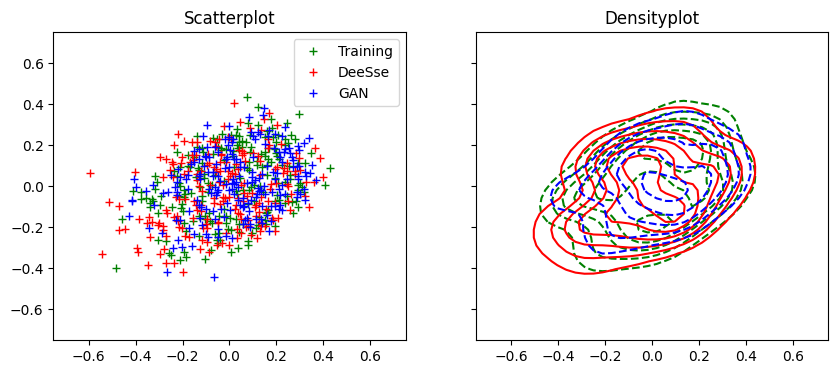

In [31]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
coos = mds.fit(swd_matrix).embedding_
        
x_test_co = coos[:Test_mds_num, 0]
y_test_co = coos[:Test_mds_num, 1]
x_mps_co = coos[Test_mds_num:Test_mds_num+MPS_mds_num, 0]
y_mps_co = coos[Test_mds_num:Test_mds_num+MPS_mds_num, 1]
x_produced_co = coos[Test_mds_num+MPS_mds_num:Test_mds_num+MPS_mds_num+GAN_mds_num, 0]
y_produced_co = coos[Test_mds_num+MPS_mds_num:Test_mds_num+MPS_mds_num+GAN_mds_num, 1]  
        
plot_lim_min = -0.75
plot_lim_max = 0.75

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(10, 4, forward=True)
        
axes[0].set_title('Scatterplot')
axes[0].set_xlim([plot_lim_min, plot_lim_max])
axes[0].set_ylim([plot_lim_min, plot_lim_max]) 
axes[0].plot(x_test_co, y_test_co, 'g+', label = 'Training')
axes[0].plot(x_mps_co, y_mps_co, 'r+', label = 'DeeSse')
axes[0].plot(x_produced_co, y_produced_co, 'b+', label = 'GAN')
axes[0].legend(loc='upper right')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 40
k_test = kde.gaussian_kde((coos.T[:, :Test_mds_num]))
xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
axes[1].set_xlim([plot_lim_min, plot_lim_max])
axes[1].set_ylim([plot_lim_min, plot_lim_max])                
test_contr = axes[1].contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='g', linestyles= 'dashed', label = 'test') 

k_mps = kde.gaussian_kde((coos.T[:, Test_mds_num:Test_mds_num+MPS_mds_num]))
xi_mps, yi_mps = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_mps = k_mps(np.vstack([xi_mps.flatten(), yi_mps.flatten()]))              
mps_contr = axes[1].contour(xi_mps, yi_mps, zi_mps.reshape(xi_mps.shape), 6, colors='r', label = 'mps') 

k_produced = kde.gaussian_kde((coos.T[:, Test_mds_num+MPS_mds_num:Test_mds_num+MPS_mds_num+GAN_mds_num]))
xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
produced_contr = axes[1].contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated') 
        
test_contr.collections[0].set_label('Training')
mps_contr.collections[0].set_label('DeeSse')
produced_contr.collections[0].set_label('GAN')
    
axes[1].set_title('Densityplot')


plt.savefig('H:/UnconditionalMDS_plot.svg' , dpi=300)

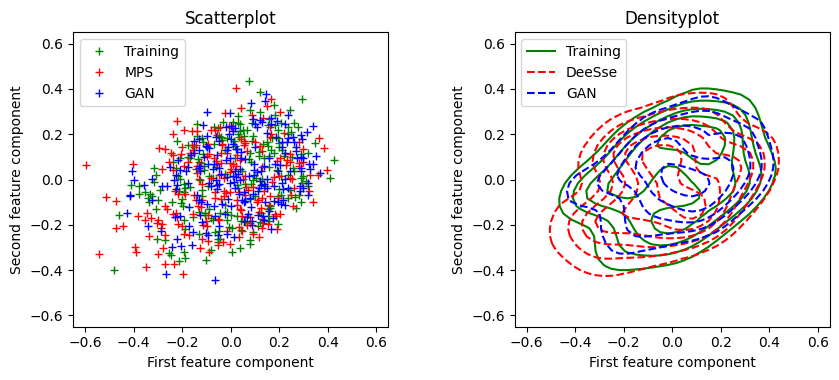

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import manifold

plot_lim_min = -0.65
plot_lim_max = 0.65

# Create a figure with 2 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(8.5, 3.9, forward=True)

# Scatterplot
axes[0].set_title('Scatterplot')
axes[0].set_xlabel('First feature component')
axes[0].set_ylabel('Second feature component')
axes[0].set_xlim([plot_lim_min, plot_lim_max])
axes[0].set_ylim([plot_lim_min, plot_lim_max]) 
axes[0].plot(x_test_co, y_test_co, 'g+', label='Training')
axes[0].plot(x_mps_co, y_mps_co, 'r+', label='MPS')
axes[0].plot(x_produced_co, y_produced_co, 'b+', label='GAN')
axes[0].legend(loc='upper left')

# Densityplot
axes[1].set_title('Densityplot')
axes[1].set_xlabel('First feature component')
axes[1].set_ylabel('Second feature component')
axes[1].set_xlim([plot_lim_min, plot_lim_max])
axes[1].set_ylim([plot_lim_min, plot_lim_max])

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 40

k_test = stats.gaussian_kde(coos[:Test_mds_num].T)
xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
test_contr = axes[1].contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='g')

k_mps = stats.gaussian_kde(coos[Test_mds_num:Test_mds_num+MPS_mds_num].T)
xi_mps, yi_mps = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_mps = k_mps(np.vstack([xi_mps.flatten(), yi_mps.flatten()]))
mps_contr = axes[1].contour(xi_mps, yi_mps, zi_mps.reshape(xi_mps.shape), 6, colors='r', linestyles='dashed')

k_produced = stats.gaussian_kde(coos[Test_mds_num+MPS_mds_num:Test_mds_num+MPS_mds_num+GAN_mds_num].T)
xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
produced_contr = axes[1].contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue', linestyles='dashed')

# Create custom legends for densityplot
handles = [plt.Line2D([], [], color='g'),
           plt.Line2D([], [], color='r', linestyle='dashed'),
           plt.Line2D([], [], color='blue', linestyle='dashed')]
labels = ['Training', 'DeeSse', 'GAN']
axes[1].legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.10)

# Save the figure
plt.savefig('H:/UnconditionalMDS_plot.svg', dpi=300)

# PCA

In [33]:
data = np.concatenate((allimgs[:200], partimgs[:200], images_plt[:200]), axis = 0)

distances = np.zeros((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    pixel1 = data[i, 0, :, :]
    for k in range(data.shape[0]):
        pixel2 = data[k, 0, :, :]
        distance = np.linalg.norm(pixel1 - pixel2)
        distances[i, k] += distance

distances = distances + distances.T - np.diag(distances.diagonal())

In [34]:
data.shape

(600, 1, 64, 64)

In [35]:
from sklearn.decomposition import PCA
eigenvalues, eigenvectors = np.linalg.eig(distances)

explained_variance_ratio = eigenvalues / eigenvalues.sum() * 100

for i, explained_var in enumerate(explained_variance_ratio):
    print(f"Dimension {i+1}: Explained Variance = {explained_var:.2f}%")
    
pca = PCA(n_components=100)
pca.fit(distances)
explained_variance_ratio_pca = pca.explained_variance_ratio_ * 100

for i, explained_var_pca in enumerate(explained_variance_ratio_pca):
    print(f"PCA Dimension {i+1}: Explained Variance = {explained_var_pca:.2f}%")

Dimension 1: Explained Variance = -81184709007325888.00%
Dimension 2: Explained Variance = 6380421551204574.00%
Dimension 3: Explained Variance = 4208470383083169.50%
Dimension 4: Explained Variance = 1666892841733829.00%
Dimension 5: Explained Variance = 1442951422153360.75%
Dimension 6: Explained Variance = 1256778867856890.50%
Dimension 7: Explained Variance = 1137494450305260.25%
Dimension 8: Explained Variance = 1086039404918334.38%
Dimension 9: Explained Variance = 973716024284985.75%
Dimension 10: Explained Variance = 937207960769567.75%
Dimension 11: Explained Variance = 819075476692320.38%
Dimension 12: Explained Variance = 775250484127529.00%
Dimension 13: Explained Variance = 740452205502515.50%
Dimension 14: Explained Variance = 726473700226380.62%
Dimension 15: Explained Variance = 659404789447780.38%
Dimension 16: Explained Variance = 622205582956221.25%
Dimension 17: Explained Variance = 581387115763423.00%
Dimension 18: Explained Variance = 550508738125992.19%
Dimension

In [36]:
explained_variance_ratio_pca

array([4.17361252e+01, 2.42991052e+01, 1.32449080e+01, 2.81681149e+00,
       1.63660471e+00, 1.37791117e+00, 1.22431091e+00, 9.84933283e-01,
       9.53007967e-01, 7.31148225e-01, 6.14779005e-01, 5.60988035e-01,
       5.40326585e-01, 4.69668550e-01, 3.96729196e-01, 3.57388654e-01,
       3.14942299e-01, 3.04178986e-01, 2.55230135e-01, 2.53024206e-01,
       2.32764625e-01, 2.10334642e-01, 1.87520457e-01, 1.58167948e-01,
       1.36086287e-01, 1.24702540e-01, 1.18643276e-01, 1.12680171e-01,
       9.93320171e-02, 9.51948985e-02, 8.84442684e-02, 7.82222334e-02,
       7.29340715e-02, 6.76369281e-02, 6.26962304e-02, 5.96835305e-02,
       5.21897901e-02, 5.17678458e-02, 5.10313087e-02, 4.62996730e-02,
       4.55080113e-02, 4.30607204e-02, 3.88945066e-02, 3.84995727e-02,
       3.64447030e-02, 3.62922124e-02, 3.48999406e-02, 3.38164048e-02,
       3.22480946e-02, 3.14071897e-02, 3.13135893e-02, 3.00586746e-02,
       2.90081185e-02, 2.84892794e-02, 2.79315927e-02, 2.76216211e-02,
      

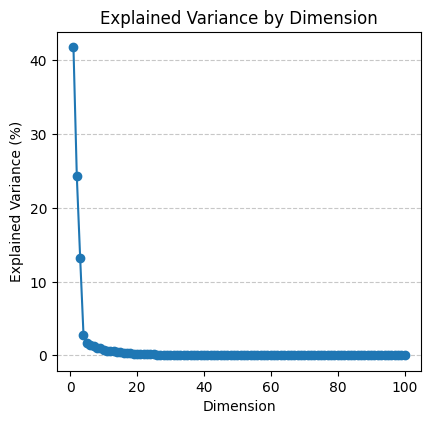

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4.7, 4.4, forward=True)
dimensions = range(1, len(explained_variance_ratio_pca) + 1)
plt.plot(dimensions, explained_variance_ratio_pca, marker='o', linestyle='-')
plt.xlabel('Dimension')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Dimension')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#fig.savefig('H:/ExplainedVariance.svg')

In [38]:
distances.shape

(600, 600)

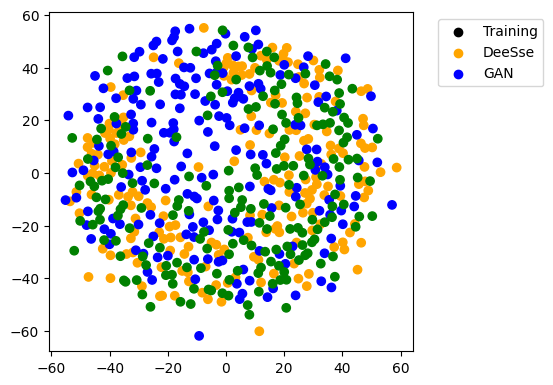

In [39]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4.7, 4.4, forward=True)

mds = MDS(n_components=2, dissimilarity='precomputed')
embeddings = mds.fit_transform(distances)

colors = ['orange'] * 200 + ['blue'] * 200 + ['green'] * 200  # 前100个为红色，中间100个为蓝色，剩下的为黑色

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors)

legend_labels = ['Training', 'DeeSse', 'GAN']
legend_handles = [plt.scatter([], [], color='black'), plt.scatter([], [], color='orange'), plt.scatter([], [], color='blue')]
plt.legend(legend_handles, legend_labels)

plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#fig.savefig('H:/MDS.svg')